# [NML24] Assignment 3: Graph Generation

TAs: [Manuel Madeira](https://people.epfl.ch/manuel.madeira) and [Yiming Qin](https://people.epfl.ch/yiming.qin)



## Students

* Team: `<your team number>`
* Students: `<student1>`, `<student2>`

## Instructions

> ⚠️ **Read carefully before starting**

**Deadline:** May 28

**Grading:**
* The integrality of Assignment 1 will be scaled to 100% and will amount to 1/3 of the overall assignments score.
* The total number of points is **60**, the points for each exercise are stated in the instructions.
* All team members will receive the same grade based on the team solution.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.


**Expected output:**

You will have coding and theoretical questions. Coding exercises shall be solved within the specified space:
```python
# Your solution here ###########################################################
...
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
Sometimes we provide variable names, such as `x = ...`; do not change names and stick to hinted typing, as they will be reused later.
Within the solution space, you can declare any other variable of function that you might need, but anything outside these lines shall not be changed, or it will invalidate your answers.

Theoretical questions shall be answered in the following markdown cell. The first line will be
```markdown
**Your answer here:**
...
```

**Solutions:**
* Your submission is self-contained in the `.ipynb` file.

* Code has to be clean and readable. Provide meaningful variable names and comment where needed.

* Textual answers in [markdown cells][md_cells] shall be short: one to two
  sentences. Math shall be written in [LaTeX][md_latex].
    **NOTE**: handwritten notes pasted in the notebook are ignored

* You cannot import any other library than we imported, unless explicitly stated.

* Make sure all cells are executed before submitting. I.e., if you open the notebook again it should show numerical results and plots. Cells not run are ignored.

* Execute your notebook from a blank state before submission, to make sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter. We might re-run cells to ensure that the code is working and corresponds to the results.

[md_cells]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html
[md_latex]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTex-equations

## Objective

Graph generative models enable the generation of synthetic graph data that mimic the characteristics of real-world graphs by approximating (implictly or explictly) their training graphs probability distribution. This is useful when real data is limited or sensitive, allowing researchers to perform simulations and experiments without privacy concerns or data scarcity issues, to detect anomalies or even to generate new unseen but plausible graphs that verify given properties. Drug discovery or protein design are two examples of real-world applications that can obviously benefit from further development of graph generative models.

The purpose of this assignment is to explore different graph generation algorithms and understand their properties. In the first part, we will explore a non-deep learning approach: Erdős–Rényi model. In the second part, we will implement a deep learning approach based on discrete diffusion. Finally, we will explore how to compare the two generative models.

**Notes:**

- Throughout this assignment, we focus on undirected and unweighted graphs that do not contain self-loops. Nevertheless, we remark that the adopted methods could naturally be extended for those settings.

- We encourage you to fill in the code by the order provided in the notebook.

In [1]:
# !pip install torch_geometric -q

In [2]:
# Importing dependencies
%matplotlib inline

from typing import List, Dict

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import torch
from sklearn import metrics
from tqdm import tqdm


import assignment3_utils as utils
from placeholder import PlaceHolder, to_dense, er_validation_step


# Set device
utils.seed_everything(0)
device = "cuda:0" if torch.cuda.is_available() else "cpu"  # cuda index to be changed
print('current device:', device)

current device: cpu


# Part 1: Erdős–Rényi model [15 points]

In this part, we explore the Erdős–Rényi model, which is a random graph model. As discussed in class, this model is defined by two parameters: the number of nodes $n$ and the probability $p$ of connecting any two nodes with an edge. The model generates a graph by connecting each pair of nodes with probability $p$.

### Question 1.1: Generating Erdős–Rényi graphs [8 points]

**1.1.1. [3 points]** Implement the function `generate_ER_graph`, which takes as input the number of nodes $n$ and the probability of an edge between every two nodes $p_{\text{ER}}$, and returns an Erdős–Rényi graph. This implementation should not use the `networkx` method `erdos_renyi_graph`.

In [3]:
def generate_ER_graph(n: int, p_er: float) -> nx.Graph:
    # Your solution here ###########################################################

    graph = np.triu(np.random.rand(n, n) < p_er, k=1)  # k=1 to avoid self loops
    graph = graph + graph.T  # make the matrix symmetric since the graph is undirected
    graph = nx.from_numpy_array(graph)

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    return graph

We will now plot a graph with 50 nodes and edge probability $p_{\text{ER}} = 0.2$ yielded by your method. We compare it to a graph coming from the `networkx` method `erdos_renyi_graph`.

In [4]:
n = 50
p_er = 0.2

g_student = generate_ER_graph(n, p_er)
g_nx = nx.erdos_renyi_graph(n, p_er)

In [5]:
print(g_student)
print(g_nx)

Graph with 50 nodes and 246 edges
Graph with 50 nodes and 252 edges


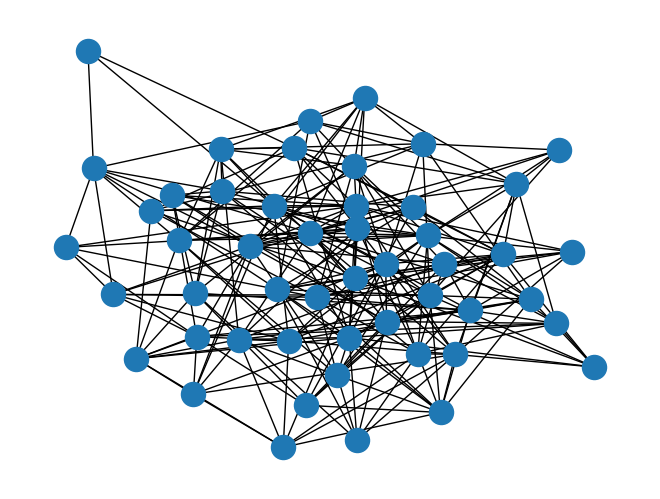

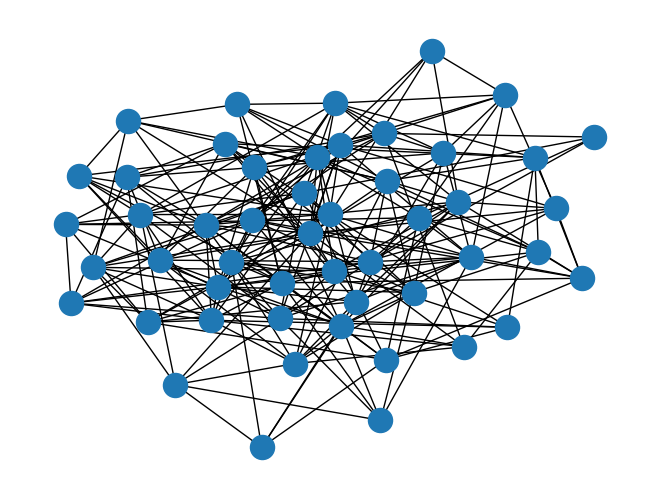

In [6]:
def plot_nx_graph(nx_graph):
    nx.draw(nx_graph)
    plt.show()


plot_nx_graph(generate_ER_graph(n, p_er))
plot_nx_graph(nx.erdos_renyi_graph(n, p_er))

As you can notice, it is hard to have any meaningful comparison or statement over the generated graphs just based on visual inspection. To overcome this limitation, a typical approach is to compute some graph statistics and perform the comparison at that level. In the next question, we explore this idea by evaluating the number of edges of the generated graphs.

**1.1.2. [2 points]** Derive the average and standard deviation of the number of edges of a Erdős–Rényi graph with $n$ nodes and $p$ probability of connection.

**Your answer here:**

There are ${n \choose 2}$ possible edges in a graph with $n$ nodes. \
Thus, there are ${{n \choose 2} \choose k}$ possible graphs with $k$ edges. \
The probability of each of these graphs is $p^k (1-p)^{{n \choose 2} - k}$ \
Hence, $P(|E| = k) = {{n \choose 2} \choose k} p^k (1-p)^{{n \choose 2} - k}$

This shows that the number of edges of a Erdős–Rényi graph follows a binomial distribution of size $N = {n \choose 2}$ and probability $p$.\
The average number of edges is thus $Np =  {n \choose 2}p$, and the standard deviation is $\sqrt{Np(1-p)} = \sqrt{{n \choose 2}p(1-p)}$ 


**1.1.3 [1 point]** **Inspect** the number of edges of the generated graphs and **compare** it with the expected number of edges.

In [7]:
# Your solution here ###########################################################
edges_our = g_student.number_of_edges()
edges_nx = g_nx.number_of_edges()
expected_edges = n * (n - 1) / 2 * p_er
std_edges = np.sqrt(n * (n - 1) / 2 * p_er * (1 - p_er))
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print(f"Expected edges: {expected_edges} ± {std_edges}")
print(f"Number of edges in our graph: {edges_our}")
print(f"Number of edges in nx graph: {edges_nx}")

Expected edges: 245.0 ± 14.0
Number of edges in our graph: 246
Number of edges in nx graph: 252


**1.1.4 [2 points]** **Describe:** What do you observe? What can you conclude?

**Hint:** Is the result statistically meaningful? Can you think of a more robust estimator to the expected number of edges?

**Your answer here:**

- We observe our both graphs have a number of edges close to the expected number of edges (less than 1 standard deviation from the expected number). 
- We would need to repeat the experiment a larger number of times and compute the mean number of edges over all of these graphs to be able to conclude.


### Question 1.2: Learning a Erdős–Rényi graph from data [7 points]

As discussed in class, the main objective of graph generative models is to capture the underlying distribution of the graph data. This is typically done by assuming a parametric model for such distribution and then learning those parameters from the observed data. Such model, where the parameters are set to the estimated ones (i.e. a trained model), is then used to sample fresh new graphs. Depending on the suitability of the assumptions of the model and on its expressivity, the generated graphs may or may not be similar to the observed ones. Throughout this assignment, we will explore different generative models and compare their performance. We will store the set of generated graphs by the different methods in the variable `graphs_to_eval` for the final evaluation.

In [8]:
graphs_to_eval = {}

In this question, we will explore how to learn a Erdős–Rényi graph from data. We start by loading the data. Note that the dataset has three splits: train, validation, and test. As usual, we will use the train split to learn the Erdős–Rényi model and evaluate the learned model on the test split. Since we will not need to do any hyperparameter tuning, we leave the validation split out for now.

The dataset used in the assignment is composed of clear community structures, consisting of densely connected nodes within communities and sparser connections across them. Each graph in this dataset contains no more than 20 nodes and is limited to a maximum of 2 clusters.

We now load the dataset.

In [9]:
dataset_path = "dataset.pt"
nx_dataset = utils.get_nx_dataset(dataset_path)

print(f"Number of graphs in the train set: {len(nx_dataset['train'])}")
print(f"Number of graphs in the validation set: {len(nx_dataset['val'])}")
print(f"Number of graphs in the test set: {len(nx_dataset['test'])}")

Number of graphs in the train set: 64
Number of graphs in the validation set: 16
Number of graphs in the test set: 20


As seen above, the ER model is parameterized by the number of nodes, $n$, and the probability of connection, $p$, so these are the parameters we must learn from the train dataset, $D$. In particular, we want to be able to sample $\hat{n} \, , \,\hat{p} \,\sim p(n, p)$, so that we can feed an ER model generator with such parameters to obtain a fresh new graph.

But how to obtain $p(n, p)$?

In the provided dataset, the number of nodes is not constant across graphs, so we can naturally model it as a categorical distribution based on the marginal probabilities of number of nodes observed in the dataset, which is equivalent to:

$$
p(n) = \frac{\sum_{G_i \in D} \mathbf{1}_{\{\text{number of nodes} (G_i)\} = n\}}}{|D|}
$$


For $p$, we will assume that it is constant, $\hat{p}$ , and independent of $n$. Therefore, we get:  
$$
p(n, p) = p(n) \hat{p} .
$$

So, under these modelling assumptions, we can now sample from the joint distribution $p(n, p)$.

**1.2.1 [5 points]** **Implement** a function to learn the proposed categorical distribution over $n$, `estimate_n_cat_dist`. **Propose and implement** a function to estimate $\hat{p}$, `estimate_p`, explaining your reasoning behind its design, and finally **implement** a function to sample from the learned model.

In [10]:
class ER_prob_model:
    def __init__(self) -> None:
        pass

    def fit(self, dataset):
        self.p = self.estimate_p(dataset)
        self.n_dist = self.estimate_n_cat_dist(dataset)
        print(f"Estimated p: {self.p}")
        print(f"Estimated n categorical distribution: {self.n_dist}")

    def estimate_n_cat_dist(self, dataset: List[nx.Graph]) -> Dict[int, float]:
        """Output must be a dictionary where keys are the number of nodes and values are the probability of that number of nodes."""
        # Your solution here ###########################################################
        n_nodes, n_graphs = np.unique(
            [g.number_of_nodes() for g in nx_dataset["train"]], return_counts=True
        )
        n_dist = dict(zip(n_nodes, n_graphs / n_graphs.sum()))
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        return n_dist

    def estimate_p(self, dataset: List[nx.Graph]) -> float:
        """Output must be a single floating point number representing the probability of an edge existing between two nodes."""
        # Your solution here ###########################################################

        p = np.mean(
            [
                g.number_of_edges()
                / (g.number_of_nodes() * (g.number_of_nodes() - 1) / 2)
                for g in nx_dataset["train"]
            ]
        )

        # TODO: which one to use?
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        return p

    def sample_ER_graphs(self, n_graphs: int) -> List[nx.Graph]:
        """Output must be a list of n_graphs ER graphs sampled from the model. Note that you should use the estimated parameters, self.n_dist and self.p (see `fit` function)."""
        # Your solution here ###########################################################
        graphs = []
        for _ in range(n_graphs):
            n = np.random.choice(list(self.n_dist.keys()), p=list(self.n_dist.values()))
            graph = generate_ER_graph(n, self.p)
            graphs.append(graph)
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        return graphs

Time to sample some fresh new graphs using your proposed model!

In [11]:
train_dataset = nx_dataset["train"]
num_graphs_to_generate = len(nx_dataset["test"])

# Learn the parameters of the ER model using the training dataset
er_model = ER_prob_model()
er_model.fit(train_dataset)

# Generate ER graphs using the learned model and visualizing the first 5
graphs_to_eval["ER"] = er_model.sample_ER_graphs(num_graphs_to_generate)

Estimated p: 0.30860474047151676
Estimated n categorical distribution: {12: 0.1875, 14: 0.3125, 16: 0.171875, 18: 0.15625, 20: 0.171875}


Let us plot the first two generated graphs with the learned model and compare them with the first two graphs of the test dataset.

Plotting generated graphs:


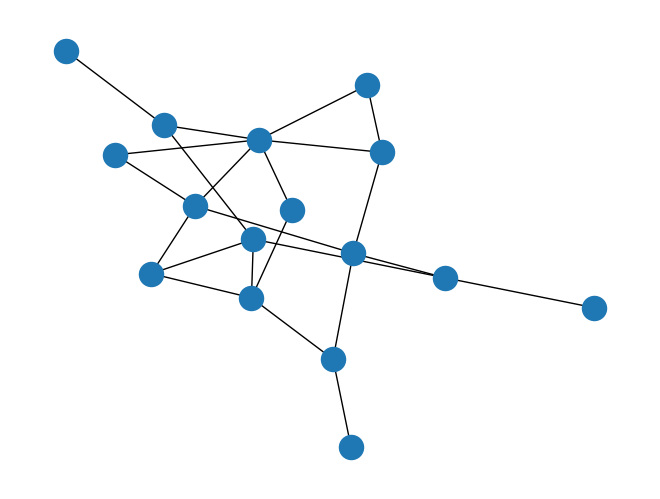

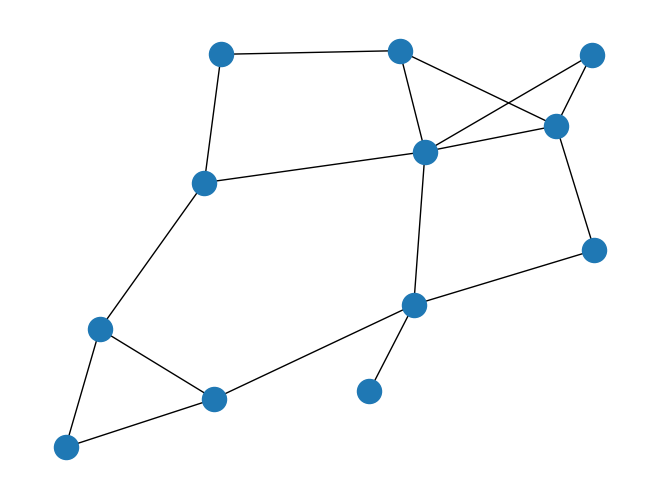

Plotting test graphs:


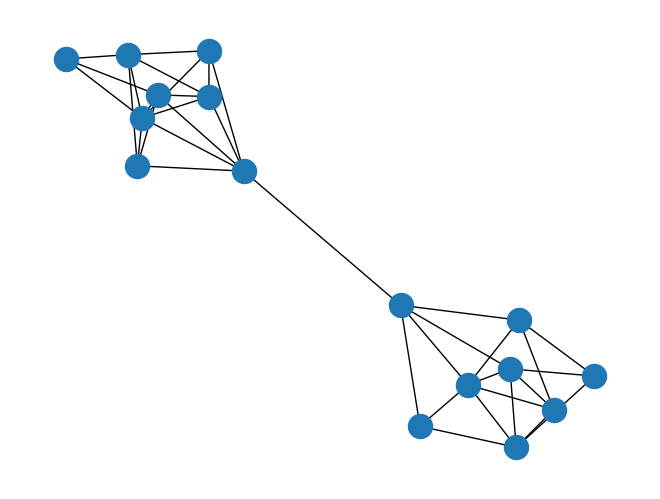

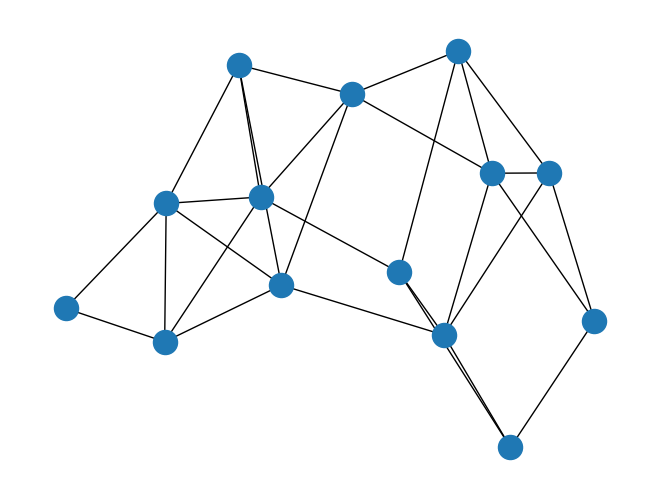

In [12]:
print("Plotting generated graphs:")
for graph in graphs_to_eval["ER"][:2]:
    plot_nx_graph(graph)

print("Plotting test graphs:")
for graph in nx_dataset["test"][:2]:
    plot_nx_graph(graph)

**1.2.2 [2 points]** Based on the generated graphs above, do you think the Erdős–Rényi (ER) model able to model the correct graph distribution? Justify your answer.

**Your answer here:**

No, the ER model is not the right choice for this dataset. Indeed, the ER model can not be used to obtain graphs with community structures, as all edges have the same probability of existing, meaning that we cannot obtain clusters with densely connected nodes and sparser connections between them



Keep these plots in the back of your mind and let us proceed now to a more sophisticated approach.

# **Part 2: Graph Diffusion Models [30 pts]**

Unlike random graph models, which rely on predetermined random distributions, deep models derive directly from data distributions and offer a robust framework for approximating any distribution by capturing complex data patterns effectively. In this section, we focus on leveraging Graph Neural Networks (GNNs) for graph generation.

Among the deep learning strategies, we encounter graph-based Generative Adversarial Networks (Graph GANs), Variational Autoencoders (VAEs), and, more recently, Diffusion Models. Each method brings unique strengths, but Diffusion Models have emerged as particularly powerful due to their excellent performance and stable training processes. We will guide you through the implementation of a simplified version of a state-of-the-art discrete diffusion model, DiGress (*Vignac* et al., DiGress, ICLR 2023).

For those of you that are familiar with the application of diffusion models to images - where we add (continuous) Gaussian noise to each pixel of an image until we achieve pure white noise, and then learn a model that can gradually recover the image from this white noise -, the intuition behind this graph diffusion model is quite similar! However, the key difference lies in the nature of the data: graphical data is often discrete, typically represented by a 0/1 adjacency matrix for general graph structures, and as categorical data for molecular graphs where each node (atom) and each edge (covalent bond) are categorized. In this setting, instead of Gaussian noise, we define a Markov Chain on the discrete space using transition matrices. If you are not familiar with Markov Chains, do not worry. In the upcoming implementation, you should be able to intuitively understand this method.



### Question 2.1 - Data Processing [5 points]

In this part of the assignment, we will implement functions related to graphical data coming from the community-based dataset (named `nx_dataset`) obtained in Part 1 and compile some statistics that will be useful in subsequent sections.

Since we are using unattributed graphs (i.e., graphs with no special node types or edge types), all we have to model is the existence/absence of edges between nodes (i.e., the adjacency matrix). Therefore, each edge belongs to one of two types: `existing` or `non-existing`.

Diffusion models are commonly applied to data modalities with a constant number of variables, such as images, where height and width are fixed, consequently fixing the total number of pixels as well. However, graph datasets do not have a fixed number of nodes nor edges. To address this, we separate the tasks of modeling the number of nodes and the adjacency matrix. The generation process involves two steps:

1. Sample the number of nodes for the graph to be generated.
2. Generate the corresponding adjacency matrix, with the node count fixed from the first step.

In the first step, we model the number of nodes using the distribution of number of nodes of the graphs in the training dataset.



**2.1.1. [2 points]** **Write a function** that, given a dataset, returns the distribution of the number of nodes. We also include '0' nodes as a valid category in our model, ensuring that the returned array spans from zero to the maximum number of nodes plus one. Thus, the shape of the array will be (max_n_nodes + 1,).

In [13]:
def count_n_node(dataset: List[nx.Graph]) -> np.ndarray:
    """Output must be a numpy array of shape (max_n_nodes + 1,) containing the probability of each number of nodes in the dataset, where max_n_nodes is the highest number of nodes found for a single graph in the dataset."""
    # Your solution here ###########################################################
    max_n_nodes = max([g.number_of_nodes() for g in dataset])
    prob = np.zeros(max_n_nodes + 1)
    for graph in dataset:
        prob[graph.number_of_nodes()] += 1
    prob /= prob.sum()

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    return prob


n_nodes_dist = torch.tensor(count_n_node(nx_dataset["train"]))
max_n_nodes = len(n_nodes_dist) - 1
print(f"The maximum number of nodes is: {max_n_nodes}")
print(f"The distribution of node numbers is: {n_nodes_dist}")

The maximum number of nodes is: 20
The distribution of node numbers is: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.1875, 0.0000, 0.3125, 0.0000, 0.1719, 0.0000,
        0.1562, 0.0000, 0.1719], dtype=torch.float64)


<!-- #### Implementing PlaceHolders -->

We now implement a class that will reveal itself quite helpful along the implementation of the diffusion model. This class, named `PlaceHolder`, will store the information regarding a batch of graphs in a flexible way. When containing a graph, it will store an edge tensor, $E$, a node tensor, $X$, and a graph-level tensor, $y$. $E$ will be a binary tensor of shape `(bs, n, n, 2)`, where `n` is the number of nodes in the graph, and `bs` is the batch-size. Accordingly, $X$ will be a tensor of shape `(bs, n, 1)`, and the graph-level tensor is a tensor of shape `(bs, 1)`. While it may seem strange at this point to store $X$ and $y$ while we are only interested in modelling the adjacency matrix, you will see that this implementation will become handy later.

To better understand what a placeholder stores, we provide the following example:
- **Probability distribution:** Let us focus on the entry $E[i,j,k,:] = [p_0, p_1]$, for any $0 \leq i < bs$ and $0 \leq j,k < n$. $p_0$ will be the probability of the edge between nodes $j$ and $k$ in the $i$-th graph of the batch being `non-existing`, while $p_1$ will be the probability of the edge between nodes $j$ and $k$ in the $i$-th graph of the batch being `existing`. Naturally, we must have $p_0 + p_1 = 1$.
<!-- - **Realization:** Importantly, a realization of such probability distribution (edges sampled from such probability distribution) can also be represented as a placeholder. For the provided example, if we sample an edge from such distribution, we will have with probability $p_0$ an edge of type `non-existing`, $E[i,j,k,:] = [1, 0]$, and with probability $p_1$ an edge of type `existing`, $E[i,j,k,:] = [0, 1]$. -->
- **Masking:** As graphs within the same batch may have different sizes, but batch operations require consistent dimensions (for efficient GPU execution), we need to mask out unnecessary parts of the tensors. For instance, if the batch size is 2, and the first graph has 10 nodes while the second has 20 nodes, then $X$ would be of size $(2, 20, 1)$, and $E$ would be of size $(2, 20, 20, 2)$. For the first graph, which only includes 10 nodes, we need to mask $X[0, 10:]$ as zero. Consequently, we need to proceed similary for the entries in $E[0, 10:, :]$ and $E[0, :, 10:]$, setting them to $[0, 0]$. Moreover, since we are considering graphs without self-loops, the diagonal of $E$ must also be masked to zero. This operation is implemented in `PlaceHolder.mask()`.

These observations show that a placeholder can store both the probability distributions and as well as their realizations (as one-hot encodings), being more suitable for our objective than storing the graphs in the usual `torch_geometric.data.Data` objects.

**2.1.2. [3 points]** In the python file `placeholder.py`, **define `e_mask1` and `e_mask2`** with dimensions `(bs, n, 1, 1)` and `(bs, 1, n, 1)` respectively for masking edges in graphs of variable sizes, and **create `diag_mask`** of shape `(bs, n, n, 1)` to eliminate self-loops by masking diagonal entries. Please run the following block after you finished your function.


In [14]:
import placeholder
import importlib

importlib.reload(placeholder)
from placeholder import PlaceHolder

# Test masking
bs = 2

n_nodes = 4
num_node_classes = 1
num_edge_classes = 2
graph_1_mask = torch.cat((torch.tensor([True] * 2), torch.tensor([False] * 2)), dim=0)
graph_2_mask = torch.cat((torch.tensor([True] * 3), torch.tensor([False] * 1)), dim=0)
node_mask = torch.vstack((graph_1_mask, graph_2_mask))
holder = PlaceHolder(
    X=torch.ones(bs, n_nodes, num_node_classes),
    E=torch.ones(bs, n_nodes, n_nodes, num_edge_classes),
    y=None,
).mask(node_mask)

print(node_mask.shape)
print(holder)
print(holder.X[0])
print(holder.X[1])
print(holder.E[0])
print(holder.E[1])

torch.Size([2, 4])
PlaceHolder(X=torch.Size([2, 4, 1]), E=torch.Size([2, 4, 4, 2]), y=None)
tensor([[1.],
        [1.],
        [0.],
        [0.]])
tensor([[1.],
        [1.],
        [1.],
        [0.]])
tensor([[[0., 0.],
         [1., 1.],
         [0., 0.],
         [0., 0.]],

        [[1., 1.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]])
tensor([[[0., 0.],
         [1., 1.],
         [1., 1.],
         [0., 0.]],

        [[1., 1.],
         [0., 0.],
         [1., 1.],
         [0., 0.]],

        [[1., 1.],
         [1., 1.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]])


### Question 2.2 - Discrete Diffusion Process [6 points]

In this part, we will simulate a discrete diffusion process over $T=1000$ steps. Discrete diffusion involves gradually corrupting categorical data towards a random distribution. For example, a vector $[0,1,0,0]$ might evolve under noise to $[0.1,0.7,0.1,0.1]$ at step $t=200$, and eventually reach a uniform distribution like $[0.25, 0.25, 0.25, 0.25]$ at $t=T=1000$.

The process utilizes a transition matrix $Q_t$ for each step $t$ in $[1,...,T]$, which is a square matrix of size $(k,k)$, where $k$ is the number of categories. The matrix $Q_t$  can be computed with $Q_t=\alpha^t \mathbb{I} + \beta^t \mathbf{1} \mathbf{1}'/n$, where $\mathbf{1}'$ is the transpose of the array $\mathbf{1}$, fully filled with ones, of size $(n, 1)$. It combines two components:
- An identity matrix $\mathbb{I}$ scaled by $\alpha^t$, preserving the original data distribution.
- A matrix $\mathbf{1} \mathbf{1}'/k$ where all entries are $1/k$, scaled by $\beta^t$, representing the noise based on a uniform distribution. Here, $\beta^t$ increases from 0 to 1 as $t$ approaches $T$, with $\alpha^t = 1 - \beta^t$.

The transition matrix $ Q_t $, defining transitions from step $ t $ to $ t+1 $, incrementally introduces noise at each step, perturbing the original distribution. In particular, the entry $Q_t[i, j]$ defines the probability of an edge (in this case, but it works for any other modelling variable laying in a discrete state-space) going from state $i$ at timestep $t$ to state $j$ at timestep $t+1$. This process is mathematically guaranteed to approach a uniform categorical distribution as $ T $ becomes large, where $T $ represents the total number of diffusion steps.

The $\beta^t$ values follow a predefined schedule, which is implemented in the following code.


We provide some introduction to the Markov chain here, in case you need.

For a Markov chain with a finite state space, the transition probabilities can be represented in a square matrix $ P $ where each element $ P_{ij} $ of the matrix represents the probability of moving from state $ i $ to state $ j $ in one step. Mathematically, $ P_{ij} $ is defined as:
$$ P_{ij} = \Pr(X_{n+1} = j \mid X_n = i) $$
where $ X_n $ is the state at time $ n $. For the matrix $ P $ to be valid, each row must satisfy the following conditions:
- $ 0 \leq P_{ij} \leq 1 $
- $ \sum_{j \in S} P_{ij} = 1 $ for all $ i \in S $

In [15]:
T = 1000

all_betas = utils.get_betas(timesteps=T, s=0.008)
all_alphas = utils.get_alphas(timesteps=T)
all_alphas_bar = utils.get_alphas_bar(all_alphas)
print(all_betas)
print(all_alphas)
print(all_alphas_bar)

tensor([[4.1241e-05],
        [4.6088e-05],
        [5.0936e-05],
        ...,
        [5.5555e-01],
        [7.5000e-01],
        [1.0000e+00]])
tensor([[0.9999],
        [0.9999],
        [0.9999],
        ...,
        [0.4444],
        [0.2500],
        [0.0000]])
tensor([[9.9990e-01],
        [9.9980e-01],
        [9.9970e-01],
        ...,
        [9.6919e-06],
        [2.4230e-06],
        [0.0000e+00]])


In the code above, we compute not only $\alpha_t$ but also $\bar{\alpha_t}^{bar}$, where $\bar{\alpha}^{bar}_t$ is the cumulative product of $\alpha_t$ from step 0 to step $t$, defined as $\bar{\alpha}^{bar}_t = \alpha_0 \times \alpha_1 \times ... \times \alpha_t$.

By using $\bar{\alpha}^{bar}$, we can directly compute the transition matrix from step 0 to step $t$ without the need of iteratively computing transitions from $0 \to 1$, $1 \to 2$, ..., $t-1 \to t$. Specifically, the transition matrix from $0$ to $t$, denoted $\bar{Q}^{bar}_t$, is calculated as $\bar{\alpha}^{bar}_t \mathbb{I}+(1-\bar{\alpha}^{bar}_t)\mathbf{1} \mathbf{1}'/k$, where $\mathbb{I}$ represents the identity matrix of size $(k,k)$.


**2.2.1. [2 points]** Please **explicitly write the expression** (no coding for now) for $\bar{Q}_t$ when $t=1$, $t=500$ and $t=1,000$ and **analyse the motivation of defining $\bar{\alpha}$** in this way intuitively. You may need to consult the variable `alphas_bar` defined above.

**Your answer here:**

...


**2.2.2. [4 points]** **Implement the computation** for $Q_t$ and $\bar{Q}_t$ for edges according to the definition above.

Hint: to make the implementation easier, you do not compute $\mathbf{1}\mathbf{1}'/k$ to create the noise matrix; instead, we define the noise distribution $\mathbf{1}'/k$ (of size `(2)` denoted as noise_dist in the following function) then expand it's dimensions to reach the correct sizes (`bs, 2, 2`).

In [16]:
def get_Q_t(betas: torch.Tensor, noise_dist: torch.Tensor, e_class=2) -> torch.Tensor:
    """
    Input:
        - betas, (bs, )
        - noise_dist, (e_class, 1) -> the noise distribution at step $t=1,000$, here we take by default (0.5, 0.5)
        - e_class, number of classes for edges
    Output:
        - q_e, (bs, e_class, e_class)
    """
    # Your solution here ###########################################################
    # print("betas_shape", betas.shape, noise_dist.shape)
    q_e = torch.outer(noise_dist, torch.ones(e_class))
    # print("q_e", q_e.shape)
    # repeat 2 times
    # multiply q[0] by beta[0] and q[1] by beta[1]
    q_e = q_e * betas[:, None]
    q_e = q_e + torch.eye(e_class, e_class)[None, :] * (1 - betas)[:, None]

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    assert (
        (q_e.sum(dim=2) - 1.0).abs() < 1e-4
    ).all()  # ensure each row of q_e represents a distribution
    return q_e


def get_Q_t_bar(
    alphas_bar: torch.Tensor, noise_dist: torch.Tensor, e_class: int = 2
) -> torch.Tensor:
    """








    Input:








        - alphas_bar, (bs, )








        - noise_dist, (e_class, 1) -> the noise distribution at step $t=1,000$, here we take by default (0.5, 0.5)








        - e_class, number of classes for edges








    Output:








        - q_e, (bs, e_class, e_class)








    """

    # Your solution here ###########################################################

    q_e = torch.outer(noise_dist, torch.ones(e_class))

    # repeat 2 times

    # multiply q[0] by beta[0] and q[1] by beta[1]

    q_e = q_e * (1 - alphas_bar)[:, None]

    q_e = q_e + torch.eye(e_class, e_class)[None, :] * (alphas_bar)[:, None]

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    assert (
        (q_e.sum(dim=2) - 1.0).abs() < 1e-4
    ).all()  # ensure each row of q_e represents a distribution

    return q_e


# example for test


noise_dist = torch.Tensor([0.5, 0.5])


betas_t = utils.get_betas(1000)[:2]


alphas_bar_t = utils.get_alphas_bar(utils.get_alphas(1000))[:2]


Qt = get_Q_t(betas_t, noise_dist, e_class=2)


Qt_bar = get_Q_t_bar(alphas_bar_t, noise_dist, e_class=2)


print(f"Qt: {Qt}, {Qt.shape}")


print(f"Qt_bar: {Qt_bar}, {Qt_bar.shape}")


# TODO remove dimension

Qt: tensor([[[9.9998e-01, 2.0620e-05],
         [2.0620e-05, 9.9998e-01]],

        [[9.9998e-01, 2.3044e-05],
         [2.3044e-05, 9.9998e-01]]]), torch.Size([2, 2, 2])
Qt_bar: tensor([[[9.9995e-01, 5.0008e-05],
         [5.0008e-05, 9.9995e-01]],

        [[9.9990e-01, 1.0002e-04],
         [1.0002e-04, 9.9990e-01]]]), torch.Size([2, 2, 2])


### Question 2.3 - Apply Noise to Data [5 points]

Now that the components of discrete diffusion are completed, we can proceed to corrupt graphs!

To achieve this, you will implement a function called `apply_noise` that introduces noise to the data. This function will take a `PlaceHolder` object as input and return a noisy `PlaceHolder` object. As we are working with unattributed graphs, we will only apply noise to the edges.

**2.3.1. [5 points]** **Complete the implementation** of the `corrupt_edges` function. You should
- Compute the corrupted edge probability distribution with `Qtb`(need to be computed by yourself) and `E`;
- Sample the noisy edges `E_t` from the corrupted multinomial distribution. Remember that the noisy edges `E_t` to return should be symmetrical and in one-hot encoding form, as they are realizations and not distributions.

In [17]:
get_Q_t_bar(all_alphas_bar[3], noise_dist, 2)

tensor([[[9.9980e-01, 2.0000e-04],
         [2.0000e-04, 9.9980e-01]]])

In [18]:
def corrupt_edges(
    E: torch.Tensor,
    t_int: torch.Tensor,
    noise_dist: torch.Tensor,
    node_mask: torch.Tensor,
):
    bs = E.size(0)
    n = E.size(1)  # number of nodes
    de = len(noise_dist)  # number of edge classes, i.e., 2

    idx = t_int.to("cpu").squeeze(-1)

    # Compute the corrupted edge probability distribution with `Qtb` and `E`
    # Your solution here ###########################################################
    Q_t_bar = get_Q_t_bar(all_alphas_bar[idx], noise_dist, de)

    assert idx.shape == (bs,)
    assert Q_t_bar.shape == (bs, de, de)
    probE = torch.zeros(bs, n, n, de)

    for graph in range(bs):

        probE[graph] = E[graph] @ Q_t_bar[graph]

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    # masked edges should also have a valid distribution instead of having all 0s.
    inverse_edge_mask = ~(node_mask.unsqueeze(1) * node_mask.unsqueeze(2))
    diag_mask = torch.eye(n).unsqueeze(0).expand(bs, -1, -1)
    probE[inverse_edge_mask] = 1 / probE.shape[-1]
    probE[diag_mask.bool()] = 1 / probE.shape[-1]
    probE = probE.reshape(bs * n * n, -1)  # (bs * n * n, de_out)

    # Sample the noisy edges `E_t` with this corrupted multinomial distribution make sure E is symmetric
    E_t = torch.multinomial(probE, 1)
    E_t = E_t.reshape(bs, n, n)
    for i in range(bs):
        # make sure the matrix is symmetric
        for j in range(n):
            for k in range(j + 1, n):
                E_t[i, j, k] = E_t[i, k, j]
    E_t = torch.nn.functional.one_hot(E_t, de).float()

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    return E_t


def apply_noise(holder, T, noise_dist, node_mask):
    # sample a random time step for each sample in the batch
    t_int = torch.randint(1, T + 1, size=(holder.E.size(0), 1))
    # apply noise to edges - the nodes remains unchanged as they have a single dimension
    E = holder.E
    E_t = corrupt_edges(E, t_int, noise_dist, node_mask)

    # Outputs masked placeholder!
    return PlaceHolder(X=holder.X, E=E_t, y=holder.y).mask(node_mask), t_int


# example for test
n = 2
bs = 3
E = torch.Tensor([[0, 1], [1, 0]]).repeat(bs, 1, 1).long()
E = torch.nn.functional.one_hot(E, 2).float()
holder = PlaceHolder(X=torch.ones(bs, n, 1), E=E, y=None)
noise_dist = torch.Tensor([0.5, 0.5])
node_mask = torch.ones(bs, n).bool()

apply_noise(holder, 1000, noise_dist, node_mask)[0].E[1, :, :, 0]

tensor([[0., 0.],
        [0., 0.]])

### Question 2.4 - Model Implementation [6 points]

In this part, we will begin the deep learning phase by designing a GNN model architecture.

In this project, a graph $G$ is represented by node features $X$ of size $(n, 1)$ and edge features $E$ of size $(n, n, 2)$. We will employ a graph transformer to model the interactions among nodes. This approach enables the integration of quadratic edge features into the attention layer, enhancing the model's ability to capture complex relationships within the graph.

More precisely, the model will take a PlaceHolder as input and return a PlaceHolder as output. The input PlaceHolder should contain $X$, $E$, and the graph feature $y$, where $y$ includes at least the time information $t$ of the diffusion process (where $t \in [0, 1000]$ and $T=1,000$). $G_0$ refers to a clean graph, while $G_t$ refers to a noised graph at step $t$. The output PlaceHolder should contain the predicted distribution (probabilities) over the clean graph $\hat{E}_0$ (X can be ignored as we set them to be 1 at all steps) given a noised graph.

But, dealing with the dense tensors of size $[bs, n, n, 2]$ could be challenging for implementing given the requirement of frequent masking. So, in this section, we start by an easier model and leverage a sparse graph representation supported directly by `pytorch geometric`. This model should be composed of a GNN trunk (whose architecture you can choose freely) to extract node features from the input graph, and some MLP layers for link prediction (in this case, prediction of probabilities for edge classes). More precisely:
- The GNN trunk should takes node features and edge index as input (several `pytorch geometric` models are readily available, fell free to use them), and output node features;
- Build input features for the MLP layers  from the previous node features. Note that the input features to the MLP for the prediction of $e_{i,j}$ should be invariant to the order of the nodes, i.e.,
for the edge prediction module `m` we should have a good `m(x_i, x_j)=m(x_j, x_i)
- These node ordering invariant edge features should be passed to the MLP layers for edge classification (probabilities prediction over edge classes).

**2.4.1. [6 points]** **Complete the simple model** architecture given in the following block.
<!-- - Define your own gnn network, and obtain node_embedding with it.
- After this, you need to perform the link prediction between all node pairs with your own link prediction module $l$, remember that $l(e_1, e_2)=l(e_2, e_1)$.
- Remember that the number of nodes for different graphs are different, so that you may need to add some masks for link prediction.
- The block should output `output_E` which is of size $(bs, n, n, 2)$. -->

In [19]:
def collapse_placeholder(holder):
    E = torch.argmax(holder.E, dim=-1)
    return PlaceHolder(X=holder.X, E=E, y=holder.y)


def holder_to_data_batch(holder, node_mask):
    # WARNING: holder should already be masked!
    data_list = []
    holder = collapse_placeholder(holder)

    for graph_idx in range(holder.X.size(0)):
        this_node_mask = node_mask[graph_idx]
        n_nodes = this_node_mask.sum()
        X = holder.X[graph_idx].squeeze()
        X = X[this_node_mask]
        E = holder.E[graph_idx]
        edge_index, edge_attr = dense_to_sparse(adj=E[:n_nodes, :n_nodes])
        y = holder.y[graph_idx]
        data = Data(x=X, edge_index=edge_index, edge_attr=edge_attr, y=y)
        data.validate(raise_on_error=True)
        data_list.append(data)

    data_batch = Batch.from_data_list(data_list)

    return data_batch

In [20]:
l = [0, 1, 2, 3]
l[0:-1:2]

[0, 2]

In [21]:
l[1::2]

[1, 3]

In [44]:
import torch.nn as nn
from torch_geometric.nn.models import MLP, GIN, GAT
from torch_geometric.data import Batch, Data
from torch_geometric.utils import dense_to_sparse
from itertools import combinations


class SimpleModel(nn.Module):
    def __init__(
        self,
        input_dims: int,
        num_GNN_layers: int,
        hidden_dims: int,
        num_MLP_layers: int,
        hidden_MLP_dims: int,
        output_dims: int,
    ):
        super().__init__()
        # Your solution here ###########################################################
        self.gnn = GIN(
            in_channels=input_dims + 1,
            out_channels=hidden_dims,
            num_layers=num_GNN_layers,
            hidden_channels=hidden_dims,  # TODO: what hidden channels?
        )
        self.mlp = MLP(
            in_channels=hidden_dims * 2,
            out_channels=output_dims,
            hidden_channels=hidden_MLP_dims,
            num_layers=num_MLP_layers,
        )
        self.mlp = torch.nn.DataParallel(self.mlp)

        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    def forward(self, holder: PlaceHolder, node_mask: torch.Tensor) -> PlaceHolder:
        max_n_nodes = holder.E.shape[1]
        bs = holder.X.shape[0]
        output_E = torch.zeros(bs, max_n_nodes, max_n_nodes, 2)
        # convert holder to data
        data = holder_to_data_batch(holder, node_mask)

        # add timestep concatenating in node features
        time = data.y
        x, edge_index = data.x, data.edge_index
        time_as_x = time[data.batch].unsqueeze(-1)
        x = torch.hstack((x.unsqueeze(-1), time_as_x))

        # Your solution here ###########################################################
        node_embeddings = self.gnn(x, edge_index)
        for graph_id in range(bs):
            graph_node_embeddings = node_embeddings[data.batch == graph_id]
            # get all possible combinations of nodes
            node_idx_combinations = np.array(
                list(
                    list(i)
                    for i in combinations(range(graph_node_embeddings.size(0)), 2)
                )
            )

            # # Preallocate tensor
            # combined_embeddings_tensor = torch.empty(
            #     (len(node_idx_combinations) * 2, 2, graph_node_embeddings.shape[1])
            # )
            # # print(combined_embeddings_tensor.shape)

            # for i, combination in enumerate(node_idx_combinations):
            #     node1, node2 = combination
            #     combined_node_embeddings = graph_node_embeddings[[node1, node2]]
            #     combined_embeddings_tensor[2 * i, :, :] = combined_node_embeddings
            #     combined_node_embeddings = graph_node_embeddings[[node2, node1]]
            #     combined_embeddings_tensor[2 * i + 1, :, :] = combined_node_embeddings

            # # Flatten the tensor
            # # print(combined_embeddings_tensor.shape)
            # combined_embeddings_tensor = combined_embeddings_tensor.flatten(start_dim=1)

            # # Make a single call to self.mlp
            # edge_probas = self.mlp(combined_embeddings_tensor)
            # edge_probas = (edge_probas[0:-1:2] + edge_probas[1::2]) / 2

            # # Assign the probabilities to output_E
            # for i, combination in enumerate(node_idx_combinations):
            #     node1, node2 = combination
            #     output_E[graph_id, node1, node2] = edge_probas[i]
            #     output_E[graph_id, node2, node1] = edge_probas[i]

            node1, node2 = node_idx_combinations[:, 0], node_idx_combinations[:, 1]
            graph_node_embeddings_1 = graph_node_embeddings[node1]
            graph_node_embeddings_2 = graph_node_embeddings[node2]
            combined_embeddings_tensor_1 = torch.cat(
                (graph_node_embeddings_1, graph_node_embeddings_2), dim=1
            )
            combined_embeddings_tensor_2 = torch.cat(
                (graph_node_embeddings_2, graph_node_embeddings_1), dim=1
            )
            combined_embeddings_tensor = torch.cat(
                (combined_embeddings_tensor_1, combined_embeddings_tensor_2), dim=0
            )

            edge_probas = self.mlp(combined_embeddings_tensor)
            edge_probas = (
                edge_probas[: len(edge_probas) // 2]
                + edge_probas[len(edge_probas) // 2 :]
            ) / 2

            output_E[graph_id, node1, node2] = edge_probas
            output_E[graph_id, node2, node1] = edge_probas

        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        output_holder = PlaceHolder(X=holder.X, E=output_E, y=None).mask(node_mask)

        return output_holder

Please use the following block to check if your implementation is correct.

An example of a valid output would be:

```
output X is represented by tensor([1.])
output E is represented by tensor([ 0.4379, -0.4380])
```

Note that the model should output logits for each edge and not actual probabilities, i.e., the output does not need to sum to 1.

In [57]:
# Check the validity of the model architecture with an simple example


bs = 32
n = 5
X = torch.ones((bs, n, 1))
E = torch.randn((bs, n, n, 2))
y = torch.randint(0, 10, (bs, 1)) / 10
node_mask = torch.Tensor([[1, 1, 1, 1, 0]]).repeat(bs, 1).bool()

args_simple = {
    "num_MLP_layers": 1,
    "num_GNN_layers": 1,
    "input_dims": 1,
    "hidden_dims": 64,
    "hidden_MLP_dims": 32,
    "output_dims": 2,
}

model_example = SimpleModel(**args_simple)


with torch.no_grad():
    res = model_example(PlaceHolder(X=X, E=E, y=y), node_mask)
print("output X is represented by", res.X[0, 0])
print("output E is represented by", res.E[0, 0, 1])

output X is represented by tensor([1.])
output E is represented by tensor([-0.1075, -0.1538])


### Question 2.5 - Model training [6 points]

Now we can proceed with the training procedure for our diffusion model. Essentially, our model $f_\theta$ is trained to predict the clean data distribution $\hat{G}_0$ given a corrupted graph $G_t$. We will use the cross-entropy loss for edges, summed up for backpropagation.

In the following question, let's write the training process!

<!-- To achieve this, we will begin by creating a dataloader using the provided code. Each data point of type networkx.graph will be converted to a data object supported by PyTorch Geometric. While the conversion process details may not be essential here, understanding the `Data` type could be beneficial in other graph-related projects. In the following part, we provide some available codes for:
1. Compare the results on training/validation dataset of ER model and diffusion model;
2. Convert sparse data to dense ones. -->

**2.5.1. [3 points]** **Complete the training process**. In this step, you need to predict the clean graph distribution, then perform the cross-entropy loss calculation and backpropagation. The `eigen_feats` will be used in the last part, and can be ignored here.

In [59]:
import random


def seed_torch(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multiple GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    random.seed(seed)
    np.random.seed(seed)


def train_model(
    model, train_dataloader, val_dataloader, n_epochs, noise_dist, T, eigen_feats
):
    # Training parameters
    seed_torch(0)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

    val_loss_list = []
    loss_list = []
    val_metric = torch.nn.CrossEntropyLoss()
    train_loss = torch.nn.CrossEntropyLoss()

    # Iterate over the batches
    for epoch_idx in range(n_epochs):
        if (epoch_idx + 1) % 10 == 0:
            optimizer.param_groups[0]["lr"] *= 0.9
            print("learning rate decayed to", optimizer.param_groups[0]["lr"])
        model.train()
        epoch_loss = []
        for batch in train_dataloader:

            # Access the batch data
            unmasked_holder, node_mask = to_dense(batch)
            noise_holder, t_int = apply_noise(unmasked_holder, T, noise_dist, node_mask)
            target_holder = unmasked_holder.mask(node_mask)

            # Prepare data for inference
            noise_holder.y = t_int.float() / T
            noise_holder = noise_holder.to(device)
            node_mask = node_mask.to(device)
            target_holder = target_holder.to(device)

            if eigen_feats is not None:
                add_feats = eigen_feats(noise_holder.E, node_mask)
                noise_holder.X = torch.cat(
                    (noise_holder.X, add_feats[2], add_feats[3]), -1
                )
                noise_holder.y = torch.cat(
                    (noise_holder.y, add_feats[0], add_feats[1]), -1
                )

            # Your solution here ###########################################################
            optimizer.zero_grad()
            # print("noise_holder x", noise_holder.X.shape)
            # print("noise_holder y", noise_holder.y.shape)
            # print("noise_holder E", noise_holder.E.shape)

            pred = model(noise_holder, node_mask)
            E_true = target_holder.E.reshape(-1, target_holder.E.shape[-1])
            E_pred = pred.E.reshape(-1, pred.E.shape[-1])
            loss = train_loss(E_pred, E_true)
            loss.backward()
            optimizer.step()

            # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

            loss = loss.detach().cpu().numpy()
            epoch_loss.append(loss)

        loss_list.append(np.mean(epoch_loss))
        # print("entering validation")
        val_loss = validation_step(
            val_dataloader, val_metric, model, noise_dist, T, eigen_feats
        )
        val_loss_list.append(val_loss)
        print("epoch", epoch_idx, "train_loss", loss_list[-1], "val_loss", val_loss)

    # Baseline
    er_train_loss = er_validation_step(train_dataloader, val_metric, er_model)
    er_train_loss_arr = er_train_loss * np.ones(n_epochs)
    er_val_loss = er_validation_step(val_dataloader, val_metric, er_model)
    er_val_loss_arr = er_val_loss * np.ones(n_epochs)
    # print(epoch_loss[-1])

    plt.plot(loss_list, label="train_loss")
    window_size = 10
    plt.plot(
        np.convolve(loss_list, np.ones(window_size) / window_size, mode="valid"),
        label="smooth train",
    )
    plt.plot(val_loss_list, label="val_loss")
    plt.plot(er_train_loss_arr, label="er_train_loss")
    # print("er_train_loss", er_train_loss_arr)
    plt.plot(er_val_loss_arr, label="er_val_loss")
    plt.legend()
    plt.show()

    # print("er_val_loss", er_val_loss_arr)
    # print("val_loss", val_loss_list)

    return model


def validation_step(val_dataloader, val_metric, model, noise_dist, T, eigen_feats):
    model.eval()

    # Get val loss
    loss_list = []
    for batch in val_dataloader:
        # Access the batch data
        unmasked_holder, node_mask = to_dense(batch)
        # print("node_mask valid", node_mask.shape)
        noise_holder, t_int = apply_noise(unmasked_holder, T, noise_dist, node_mask)
        target_holder = unmasked_holder.mask(node_mask)

        # Prepare data for inference
        noise_holder.y = t_int.float() / T
        noise_holder = noise_holder.to(device)
        node_mask = node_mask.to(device)
        target_holder = target_holder.to(device)

        # get values for training model
        with torch.no_grad():
            if eigen_feats is not None:
                add_feats = eigen_feats(noise_holder.E, node_mask)
                noise_holder.X = torch.cat(
                    (noise_holder.X, add_feats[2], add_feats[3]), -1
                )
                noise_holder.y = torch.cat(
                    (noise_holder.y, add_feats[0], add_feats[1]), -1
                )

            pred = model(noise_holder, node_mask)
            E_true = target_holder.E.reshape(-1, target_holder.E.shape[-1])
            E_pred = pred.E.reshape(-1, pred.E.shape[-1])
            loss = val_metric(E_pred, E_true)
            loss_list.append(loss.detach().cpu().numpy())

    val_loss = sum(loss_list) / len(loss_list)

    return val_loss

**2.5.2. [3 points]** **Define your own hyperparameters** and use the `train_model` function to **train your model**. **Comment on your training curve.**

**Remark**: we will assign maximum grade in this question to any model implementation whose validation loss is below the expected validation loss for the ER model (which will be shown in the figure when you run the function `train_model`). Please do not spend too much time over optimizing your model beyond that baseline.

epoch 0 train_loss 0.58240294 val_loss 0.5622963905334473
epoch 1 train_loss 0.5629113 val_loss 0.5416344404220581
epoch 2 train_loss 0.5400746 val_loss 0.5189369469881058
epoch 3 train_loss 0.505667 val_loss 0.4994441717863083
epoch 4 train_loss 0.48829222 val_loss 0.47122327983379364
epoch 5 train_loss 0.48031443 val_loss 0.46244266629219055
epoch 6 train_loss 0.45957276 val_loss 0.4463824927806854
epoch 7 train_loss 0.44544297 val_loss 0.4320060610771179
epoch 8 train_loss 0.42864263 val_loss 0.4200959950685501
learning rate decayed to 4.5e-05
epoch 9 train_loss 0.41820306 val_loss 0.41107557713985443
epoch 10 train_loss 0.40966934 val_loss 0.4031742215156555
epoch 11 train_loss 0.40164727 val_loss 0.3960460424423218
epoch 12 train_loss 0.3947692 val_loss 0.39049363136291504
epoch 13 train_loss 0.38913915 val_loss 0.38583560287952423
epoch 14 train_loss 0.3856529 val_loss 0.3814283609390259
epoch 15 train_loss 0.3816245 val_loss 0.3792392611503601
epoch 16 train_loss 0.37779367 val_

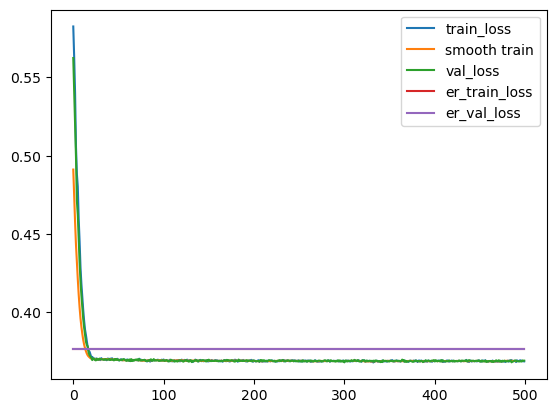

In [60]:
# Training
bs = 32
train_dataloader = utils.nx_list_to_dataloader(nx_dataset["train"], bs=bs)
val_dataloader = train_dataloader
test_dataloader = utils.nx_list_to_dataloader(nx_dataset["test"], bs=bs)
n_epochs = 500  # you can try epoches if you want

# Your solution here ###########################################################
simple_model = SimpleModel(**args_simple).to(device)
model = train_model(
    simple_model, train_dataloader, val_dataloader, n_epochs, noise_dist, T, None
)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


**Your answer here:**

...

### Question 2.6 - Generation (Reverse Process) [2 points]

With the trained model, we can now generate new graphs from uniform noise!

As discussed in D3PM (*Austin* et al., D3PM, 2021) and DiGress, for discrete data $X$, the generation is done step by step from $t=T$ to $t=1$.

Intuitively, the procedure is as follows:
- first, use the trained model $f_\theta$ to predict a distribution over $x_0$.
- noise the previously obtained distribution for $x_0$ back $x_{t-1}$ using the posterior of the forward process, given by:

$$
q(x_{t-1}|x_t,x_0)=\frac{q(x_t|x_{t-1}, x_0)q(x_{t-1}|x_0)}{q(x_t|x_0)} = Cat(x_{t-1};p=\frac{x_tQ_t^\top\odot x_0\bar{Q}_{t-1}}{x_0\bar{Q}_tx_t^\top})
$$

- sample a graph from the distribution over $x_{t-1}$

This step by step denoising is crucial for the success of diffusion models as it allows to deconstruct the complex task of mapping two distributions into smaller subproblems.

If some of these descriptions sounded a bit confusing, do not worry, we provide the (almost) complete code for it. You only have to care about the sampling of the number of nodes - as simple as for the ER model! Nevertheless, if you are interested, you are free to check its full implementation below.

**2.6.1. [2 points]** **Sample the number of nodes** (`n_nodes`) for the graph to be generated, and **retrieve the node mask** (`node_mask`) with it.

In [61]:
def sample_graph(
    model, noise_dist, T, n_graphs, num_timesteps_to_save=5, eigen_feats=None
):
    seed_torch(0)
    max_n_nodes = len(n_nodes_dist) - 1
    de = len(noise_dist)

    # Your solution here ###########################################################
    # sample the number of nodes for n_graphs
    n_nodes = torch.multinomial(n_nodes_dist, n_graphs, replacement=True)
    node_mask = torch.zeros(n_graphs, max_n_nodes).bool()
    for i in range(n_graphs):
        node_mask[i, : n_nodes[i]] = True
    # print(n_nodes)
    print("node_mask", node_mask.shape)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    # sample a purely noised graph at step T
    limit_dist = noise_dist.repeat(n_graphs * max_n_nodes * max_n_nodes, 1)
    limit_E = limit_dist.multinomial(1, replacement=True)
    limit_E = limit_E.reshape(n_graphs, max_n_nodes, max_n_nodes)
    limit_E = torch.nn.functional.one_hot(limit_E, 2).float()
    limit_E = utils.symmetrize(limit_E)

    holder = (
        PlaceHolder(
            X=torch.ones(n_graphs, max_n_nodes, 1),
            E=limit_E,
            y=torch.Tensor([1]).unsqueeze(-1).repeat(n_graphs, 1),
        )
        .to(device)
        .mask(node_mask)
    )

    saving_steps = torch.linspace(0, T, num_timesteps_to_save).round()
    saved_holders = [holder.to("cpu")]  # save initial holder
    print("Saving timesteps: ", saving_steps)
    model.eval()

    with torch.no_grad():
        for t in tqdm(range(1, T + 1)[::-1]):
            steps = torch.Tensor([t]).unsqueeze(-1).repeat(n_graphs, 1).to(device)
            # print(steps.shape)
            steps_next = steps - 1
            holder.y = steps / T

            if eigen_feats is not None:
                add_feats = eigen_feats(holder.E, node_mask)
                holder.X = torch.cat((holder.X, add_feats[2], add_feats[3]), -1)
                holder.y = torch.cat((holder.y, add_feats[0], add_feats[1]), -1)

            pred_G0 = model(holder, node_mask)
            pred_E = torch.softmax(pred_G0.E, dim=-1)
            shape_E = pred_E.shape
            E_t = holder.E.to(torch.float32)  # bs, n, n, 2

            # transition matrix used in the reverse process of size (bs, 2, 2)
            Qtb = get_Q_t_bar(
                all_alphas_bar[steps[:, 0].long().to("cpu")], noise_dist, e_class=2
            ).to(device)
            # print("Qtb", Qtb.shape)
            Qsb = get_Q_t_bar(
                all_alphas_bar[steps_next[:, 0].long().to("cpu")], noise_dist, e_class=2
            ).to(device)
            Qt = get_Q_t(
                all_betas[steps[:, 0].long().to("cpu")], noise_dist, e_class=2
            ).to(device)
            # print("Qt", Qt.shape)
            # print("all_betas", all_betas[steps[:, 0].long().to("cpu")].shape)

            # posterior computation
            E_t = E_t.flatten(start_dim=1, end_dim=-2).to(torch.float32)  # bs x N x dt

            Qt_T = Qt.transpose(-1, -2)  # bs, dt, d_t-1
            # print(E_t.shape, Qt_T.shape)
            left_term = E_t @ Qt_T  # bs, N, d_t-1
            left_term = left_term.unsqueeze(dim=2)  # bs, N, 1, d_t-1

            right_term = Qsb.unsqueeze(1)  # bs, 1, d0, d_t-1
            numerator = left_term * right_term  # bs, N, d0, d_t-1

            X_t_transposed = E_t.transpose(-1, -2)  # bs, dt, N

            prod = Qtb @ X_t_transposed  # bs, d0, N
            prod = prod.transpose(-1, -2)  # bs, N, d0
            denominator = prod.unsqueeze(-1)  # bs, N, d0, 1
            denominator[denominator == 0] = 1e-6

            p_s_and_t_given_0_E = numerator / denominator

            # noise back
            pred_E = pred_E.reshape((n_graphs, -1, pred_E.shape[-1]))
            weighted_E = pred_E.unsqueeze(-1) * p_s_and_t_given_0_E  # bs, N, d0, d_t-1
            unnormalized_prob_E = weighted_E.sum(dim=-2)
            unnormalized_prob_E[torch.sum(unnormalized_prob_E, dim=-1) == 0] = 1e-5
            prob_E = unnormalized_prob_E / torch.sum(
                unnormalized_prob_E, dim=-1, keepdim=True
            )
            prob_E = prob_E.reshape(
                n_graphs, max_n_nodes, max_n_nodes, pred_E.shape[-1]
            )

            # sample at timestep t-1
            E_s = prob_E.reshape(-1, de).multinomial(1, replacement=True)
            E_s = torch.nn.functional.one_hot(E_s, 2).float().reshape(shape_E)
            E_s = utils.symmetrize(E_s)

            assert (E_s == torch.transpose(E_s, 1, 2)).all()
            assert E_s.shape == E_s.shape

            holder = (
                PlaceHolder(
                    X=torch.ones(n_graphs, max_n_nodes, 1).to(device),
                    E=E_s,
                    y=steps_next / T,
                )
                .to(device)
                .mask(node_mask)
            )

            # Save graphs
            if t - 1 in saving_steps:
                saved_holders.append(holder.to("cpu"))

    return holder, saved_holders

The following block enables you to sample new graphs with the trained model.

In [62]:
num_graphs_to_generate = len(nx_dataset["test"])

simple_model_graphs, simple_model_intermediate_graphs = sample_graph(
    simple_model,
    noise_dist,
    T,
    num_graphs_to_generate,
    num_timesteps_to_save=5,
    eigen_feats=None,
)

graphs_to_eval["simple"] = simple_model_graphs.to_nx_graph_list()

node_mask torch.Size([20, 20])
Saving timesteps:  tensor([   0.,  250.,  500.,  750., 1000.])


100%|██████████| 1000/1000 [01:15<00:00, 13.24it/s]


# **Part 3: Evaluation and Comparison [15 pts]**


### Question 3.1 - Visualization [2 points]
We will visualize the denoising process of the diffusion model. While the diffusion process is expected to gradually corrupt the graph towards the prescribed limit distribution, in the denoising process one should expect the reverse. We will visualize 2 graphs (one per row) at different steps of the diffusion process using the provided function `plot_intermediate_graphs`.


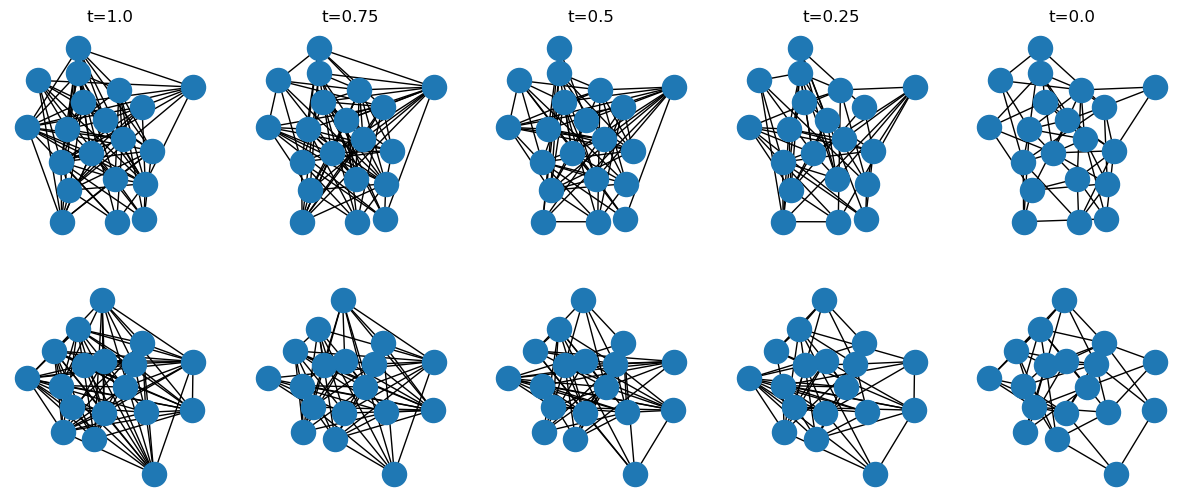

In [63]:
utils.plot_intermediate_graphs(simple_model_intermediate_graphs, T, 2)

**3.1.1. [2 points]** **Comment briefly.** What do you observe? Are the final graphs similar to what you expected? What can you conclude from the visualization?



**Your answer here:**

...




### Question 3.2: Quantitative Comparison [5 points]

As noticed in Part 1, evaluating graph generation just based on visual inspection is not enough. We need to compare the generated graphs quantitatively. One common approach in graph generation is to compare populations of graph-wise statistics. In this case, we will consider two different statistics:
- The degree distribution of the nodes.
- The clustering coefficient of the nodes.

For each graph, we will get a distribution (in practice, an histogram) of nodes degrees and a distribution (similarly, an histogram) of node clustering coefficients. Consequently for a graph dataset, we will get a set of histograms for each statistic. Therefore, we can compare how similar two datasets are in terms of the chosen statistic by comparing the two sets of histograms through some notion of "distance" between distributions. The more similar the two sets of histograms are, the more similar the two datasets are (at least, in terms of that statistic), so smaller should be the distance between them. In graph generation, it is usual to use the Maximum Mean Discrepancy (MMD) as such notion of "distance". You do not have to worry too much about it, just know that it is a measure of the similarity of distributions.

Finally, since such notion of "distance" is not easily interpretable, we consider as a final result the following ratio (with some abuse of notation):

$$
\frac{\operatorname{MMD} \, (\text{generated}, \text{test})}{\operatorname{MMD} \, (\text{train}, \text{test})},
$$

where generated, train, and test consist of the histograms of a statistic for the generated graphs, the training graphs, and the test graphs, respectively. This ratio will be our final evaluation metric, since in principle, the best MMD we could hope for is the one between the training and test datasets, as the training dataset is the one we are trying to approximate. Therefore, the expected optimal (minimum) value is 1.

<!-- In graph generation, it is usual to use the [Maximum Mean Discrepancy](https://jmlr.csail.mit.edu/papers/v13/gretton12a.html) (MMD) as such notion of "distance". You do not have to worry too much about it, just know that it is a measure of the similarity of distributions.

To make you more familiar, an alternative to MMD could be the widely know Kullback-Leibler divergence (it suffers from some limitations, such as the assymetry in its inputs, sensitivity to zero probabilities, etc). In any case, we provide you an implementation of the MMD function.

Finally, since such notion of "distance" is not easily interpretable, we consider as a final result the following ratio (with some abuse of notation):

$$
\frac{\operatorname{MMD} \, (\text{generated}, \text{test})}{\operatorname{MMD} \, (\text{train}, \text{test})},
$$

where generated, train, and test consist of the histograms of a statistic for the generated graphs, the training graphs, and the test graphs, respectively. This ratio will be our final evaluation metric, since in principle, the best MMD we could hope for is the one between the training and test datasets, as the training dataset is the one we are trying to approximate. Therefore, the expected optimal (minimum) value is 1. -->


**3.2.1. [4 points]** **Implement the functions** `...hist_array`.
You can use functions from *networkx* (e.g., `nx.degree_histogram`, `nx.clustering`, and `nx.histogram`).

In [64]:
def get_degree_hist_array(
    nx_dataset: List[nx.Graph], max_degree: int = 20
) -> np.ndarray:
    """The output should be an np.array of shape (len(nx_dataset), max_degree),  where each row corresponds to the degree histogram obtained for a different graph of the dataset."""
    deg_hist_array = np.zeros((len(nx_dataset), max_degree))
    # Your solution here ###########################################################
    for i, graph in enumerate(nx_dataset):
        hist = nx.degree_histogram(graph)[:max_degree]
        deg_hist_array[i, : len(hist)] = hist
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    return deg_hist_array


def get_clustering_hist_array(nx_dataset, num_bins=10) -> np.ndarray:
    """The output should be an np.array of shape (len(nx_dataset), num_bins), where each row corresponds to the node cluster coefficient histogram obtained for a different graph of the dataset."""
    clustering_hist_array = np.zeros((len(nx_dataset), num_bins))
    # Your solution here ###########################################################
    for i, graph in enumerate(nx_dataset):
        clustering_coeff = nx.clustering(graph)
        clustering_hist_array[i] = np.histogram(
            list(clustering_coeff.values()), bins=num_bins
        )[0]

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    return clustering_hist_array


dict_stat_fn = {
    "degree": get_degree_hist_array,
    "clustering": get_clustering_hist_array,
}
final_results = utils.QuantitativeResults(
    dict_stat_fn=dict_stat_fn,
    train_dataset=nx_dataset["train"][:20],
    test_dataset=nx_dataset["test"],
)
for gen_method, gen_dist in graphs_to_eval.items():
    final_results.add_results(gen_method, gen_dist)
final_results.show_table()

,ref,ER,simple
degree,1,3.082199,2.131587
clustering,1,2.684147,2.566614


**3.2.2. [1 point]** Comment briefly on this quantitative result.



**Your answer here:**

...



### Question 3.3: Improving Results [8 points]

In this section, we will implement a more sophisticated architecture, `GraphTransformer`, provided in `transformer_model.py`. This new architecture enhances interactions through:

- Modules that effectively integrate node, edge, and graph-level features;
- A refined masking mechanism that allows operations on dense tensors instead of relying solely on edge lists.

Your task is to readily utilize this architecture, and compare its performance with the simpler model previously discussed.

**3.3.1. [4 points]** Using the **model provided**, **retrain**, **resample**, **replot** and **re-evaluate**. **Comment** briefly on your observations.

Remark: You may observe a lot of fluctuations on the curve, it's normal so do not worry about that. Look at the `smooth_train` in this case could be helpful. Please refer to what we did in the previous model to show your results :)

epoch 0 train_loss 0.37962496 val_loss 0.34798936545848846
epoch 1 train_loss 0.35473987 val_loss 0.3365515023469925
epoch 2 train_loss 0.34595183 val_loss 0.3221719115972519
epoch 3 train_loss 0.3027555 val_loss 0.3234749734401703
epoch 4 train_loss 0.30374697 val_loss 0.2730101943016052
epoch 5 train_loss 0.32107982 val_loss 0.3064289540052414
epoch 6 train_loss 0.3078866 val_loss 0.30852264165878296
epoch 7 train_loss 0.3060705 val_loss 0.27272436022758484
epoch 8 train_loss 0.2746843 val_loss 0.28603464365005493
learning rate decayed to 4.5e-05
epoch 9 train_loss 0.29481143 val_loss 0.2839335799217224
epoch 10 train_loss 0.28908464 val_loss 0.2911875247955322
epoch 11 train_loss 0.30646068 val_loss 0.30007970333099365
epoch 12 train_loss 0.29039475 val_loss 0.3009791672229767
epoch 13 train_loss 0.29139328 val_loss 0.2905648946762085
epoch 14 train_loss 0.27373314 val_loss 0.3052729368209839
epoch 15 train_loss 0.28570092 val_loss 0.2824971526861191
epoch 16 train_loss 0.30405653 v

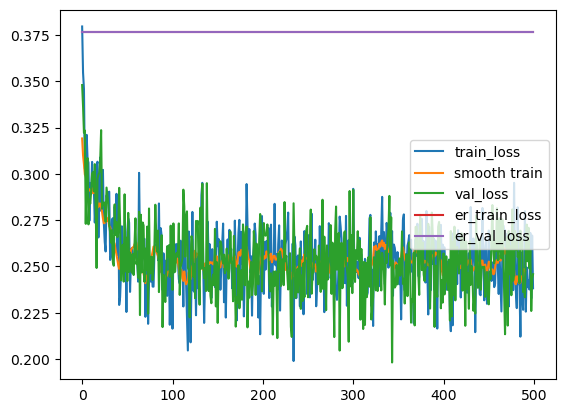

node_mask torch.Size([20, 20])
Saving timesteps:  tensor([   0.,  250.,  500.,  750., 1000.])


100%|██████████| 1000/1000 [02:20<00:00,  7.10it/s]


,ref,ER,simple,transformer
degree,1,3.082199,2.131587,2.646326
clustering,1,2.684147,2.566614,2.564907


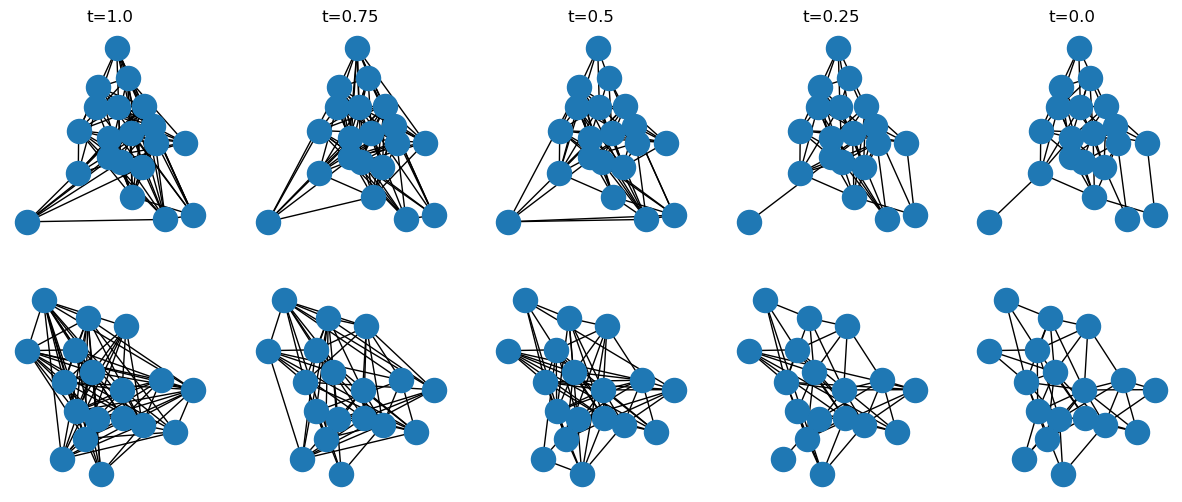

In [65]:
from transformer_model import GraphTransformer

# Some hyper-parameters by default you can use - of course you can change them if you want !

args_gt = {
    "n_layers": 4,
    "n_head": 8,
    "input_dims": {"X": 1, "E": 2, "y": 1},
    "hidden_dims": {"X": 256, "E": 256, "y": 256, "dx": 64, "de": 64, "dy": 64},
    "output_dims": {"X": 1, "E": 2, "y": 1},
}
n_epochs = 500


# Your solution here ###########################################################

gt_model = GraphTransformer(**args_gt).to(device)
# Train
gt_model = train_model(
    gt_model, train_dataloader, val_dataloader, n_epochs, noise_dist, T, None
)


# Generate
gt_model_graphs, gt_model_intermediate_graphs = sample_graph(
    gt_model,
    noise_dist,
    T,
    num_graphs_to_generate,
    num_timesteps_to_save=5,
    eigen_feats=None,
)

graphs_to_eval["transformer"] = gt_model_graphs.to_nx_graph_list()


# Visualize and evaluate
utils.plot_intermediate_graphs(gt_model_intermediate_graphs, T, 2)

for gen_method, gen_dist in graphs_to_eval.items():
    final_results.add_results(gen_method, gen_dist)
final_results.show_table()

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**Your answer here:**

...


Even with such an expressive architecture, the results are still not satisfactory!

As introduced in the lectures, GNN's expressivity is limited. To further enhance the model expressivity, it is a common practice to provide the model some additional information. One of the most performing and most popular additional features is the eigenvalues and the eigenvectors of the Laplacian matrix. While the former can be passed as additional graph-level features, the latter can be passed as additional node-level features.

At this point, we can now better motivate the use of the `PlaceHolder` class. Previously, the reason was not obvious since `X` and `y` did not contain much information. Contrarily, now we will pass the `eigen_feats` through them (you can re-check the `train_model` function implementation to better understand what is happening under the hood). The eigenvalues and eigenvectors of the Laplacian can be obtained from the `EigenFeatures` class, provided in `nml24_assignment3.py` (already imported in this ipynb as `utils`). Please initialize that class with the input `'all'`.

**3.3.2. [4 points]** Similarly, **use the model and EigenFeatures class provided**, **retrain**, **resample**, **replot** and **re-evaluate**. **Comment** briefly on your observations. Do not remember to change the `input_dims` in `args_gt_pp` to run your codes.

epoch 0 train_loss 0.3278579 val_loss 0.3295320123434067
epoch 1 train_loss 0.32873774 val_loss 0.3089819550514221
epoch 2 train_loss 0.3183779 val_loss 0.30173397064208984
epoch 3 train_loss 0.30352992 val_loss 0.29984351992607117
epoch 4 train_loss 0.3268376 val_loss 0.3016940504312515
epoch 5 train_loss 0.3292325 val_loss 0.3016710430383682
epoch 6 train_loss 0.3045177 val_loss 0.3010420501232147
epoch 7 train_loss 0.29117513 val_loss 0.30179230868816376
epoch 8 train_loss 0.27157807 val_loss 0.2841801345348358
learning rate decayed to 4.5e-05
epoch 9 train_loss 0.2927075 val_loss 0.28997108340263367
epoch 10 train_loss 0.2902525 val_loss 0.2683669924736023
epoch 11 train_loss 0.30244157 val_loss 0.3065990060567856
epoch 12 train_loss 0.26453096 val_loss 0.287371426820755
epoch 13 train_loss 0.27506047 val_loss 0.30182789266109467
epoch 14 train_loss 0.30066878 val_loss 0.2881370633840561
epoch 15 train_loss 0.29471365 val_loss 0.3031257092952728
epoch 16 train_loss 0.26992187 val_l

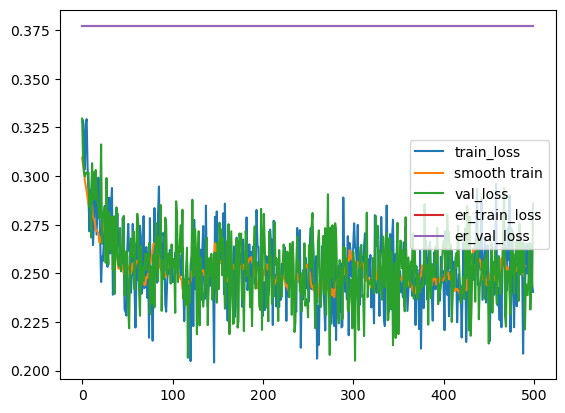

node_mask torch.Size([20, 20])
Saving timesteps:  tensor([   0.,  250.,  500.,  750., 1000.])


100%|██████████| 1000/1000 [02:35<00:00,  6.41it/s]


,ref,ER,simple,transformer,eigen_features
degree,1,3.082199,2.131587,2.646326,2.908521
clustering,1,2.684147,2.566614,2.564907,1.674107


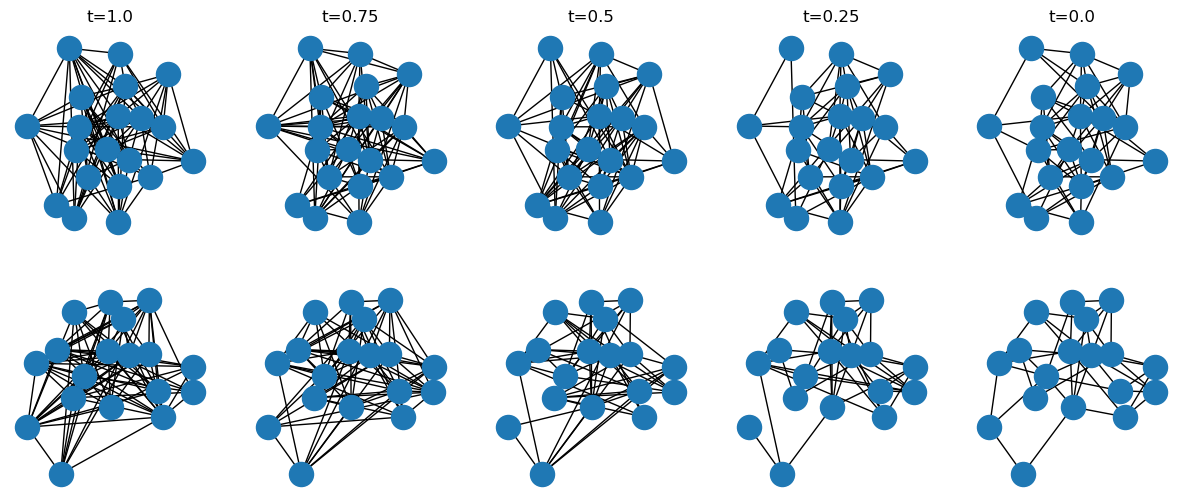

In [66]:
args_gt_pp = args_gt
args_gt_pp["input_dims"] = {"X": 7, "E": 2, "y": 7}
eigen_feats = utils.EigenFeatures("all")

# Your solution here ###########################################################

eigen_model = GraphTransformer(**args_gt_pp).to(device)
# Train
eigen_model = train_model(
    eigen_model, train_dataloader, val_dataloader, n_epochs, noise_dist, T, eigen_feats
)


# Generate
eigen_model_graphs, eigen_model_intermediate_graphs = sample_graph(
    eigen_model,
    noise_dist,
    T,
    num_graphs_to_generate,
    num_timesteps_to_save=5,
    eigen_feats=eigen_feats,
)

graphs_to_eval["eigen_features"] = eigen_model_graphs.to_nx_graph_list()


# Visualize and evaluate
utils.plot_intermediate_graphs(eigen_model_intermediate_graphs, T, 2)

for gen_method, gen_dist in graphs_to_eval.items():
    final_results.add_results(gen_method, gen_dist)
final_results.show_table()

**Your answer here:**

...



In [69]:
import pickle

# save the three models:
torch.save(simple_model.state_dict(), "simple_model.pth")
torch.save(gt_model.state_dict(), "gt_model.pth")
torch.save(eigen_model.state_dict(), "eigen_model.pth")

# save graphs to evaluate
with open("graphs_to_eval.pkl", "wb") as f:
    pickle.dump(graphs_to_eval, f)

# save the final results
with open("final_results.pkl", "wb") as f:
    pickle.dump(final_results, f)

# load
with open("graphs_to_eval.pkl", "rb") as f:
    graphs_to_eval = pickle.load(f)

# # load the three models:
# simple_model = SimpleModel(**args_simple).to(device)
# simple_model.load_state_dict(torch.load("simple_model.pth"))
# simple_model.eval()

# gt_model = GraphTransformer(**args_gt).to(device)
# gt_model.load_state_dict(torch.load("gt_model.pth"))
# gt_model.eval()

# eigen_model = GraphTransformer(**args_gt_pp).to(device)
# eigen_model.load_state_dict(torch.load("eigen_model.pth"))
# eigen_model.eval()

In [73]:
dict_stat_fn = {
    "degree": get_degree_hist_array,
    "clustering": get_clustering_hist_array,
}
final_results = utils.QuantitativeResults(
    dict_stat_fn=dict_stat_fn,
    train_dataset=nx_dataset["train"][:20],
    test_dataset=nx_dataset["test"],
)
for gen_method, gen_dist in graphs_to_eval.items():
    final_results.add_results(gen_method, gen_dist)
final_results.show_table()

,ref,ER,simple,transformer,eigen_features
degree,1,3.082199,2.131587,2.646326,2.908521
clustering,1,2.684147,2.566614,2.564907,1.674107


In [74]:
dict_stat_fn = {
    "degree": get_degree_hist_array,
    "clustering": get_clustering_hist_array,
}
final_results = utils.QuantitativeResults(
    dict_stat_fn=dict_stat_fn,
    train_dataset=nx_dataset["train"],
    test_dataset=nx_dataset["test"],
)
for gen_method, gen_dist in graphs_to_eval.items():
    final_results.add_results(gen_method, gen_dist)
final_results.show_table()

,ref,ER,simple,transformer,eigen_features
degree,1,4.793358,3.314990,4.115500,4.523259
clustering,1,5.898904,5.640604,5.636853,3.679157
